In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import re
import string 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

In [153]:
df = pd.read_csv('youtube_comments_EscapeSKZ.csv')

In [154]:
df.head()

,Author,Comment,Likes,Published_At,Replies
0,@Raisha5594,My lovely bamgchan,0,2025-03-30T05:36:43Z,0
1,@adaniadaha5667,That high note they did😮,0,2025-03-30T05:13:12Z,0
2,@hotlatte-ev2gf,I like this concept,2,2025-03-30T05:07:30Z,0
3,@melizazueta,I love banchan especially kimchi,1,2025-03-30T04:29:00Z,0
4,@E.B1963,Ugh they both look like the hot toxic boyfrien...,2,2025-03-30T04:15:37Z,0


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Author        11997 non-null  object
 1   Comment       12000 non-null  object
 2   Likes         12000 non-null  int64 
 3   Published_At  12000 non-null  object
 4   Replies       12000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 468.9+ KB


In [156]:
df_skz = df.dropna()

In [157]:
df_skz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11997 entries, 0 to 11999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Author        11997 non-null  object
 1   Comment       11997 non-null  object
 2   Likes         11997 non-null  int64 
 3   Published_At  11997 non-null  object
 4   Replies       11997 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 562.4+ KB


In [158]:
df_skz.drop_duplicates()

,Author,Comment,Likes,Published_At,Replies
0,@Raisha5594,My lovely bamgchan,0,2025-03-30T05:36:43Z,0
1,@adaniadaha5667,That high note they did😮,0,2025-03-30T05:13:12Z,0
2,@hotlatte-ev2gf,I like this concept,2,2025-03-30T05:07:30Z,0
3,@melizazueta,I love banchan especially kimchi,1,2025-03-30T04:29:00Z,0
4,@E.B1963,Ugh they both look like the hot toxic boyfrien...,2,2025-03-30T04:15:37Z,0
...,...,...,...,...,...
11995,@minhoulticim,of acayip iyi,1,2025-03-24T14:37:37Z,0
11996,@TaemAteSKZ,I&#39;m going to live here.,0,2025-03-24T14:37:36Z,0
11997,@Lazroyal,It’s giving mischievous brothers but brothers ...,0,2025-03-24T14:37:35Z,0
11998,@neZumii01,OKOKOK WAIT WHAAAAAT?! Here looks like they we...,0,2025-03-24T14:37:36Z,0


In [159]:
def cleaningText(text):
    # Hapus mention, hashtag, RT
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    
    # Hapus link
    text = re.sub(r"http\S+", '', text)
    
    # Hapus angka
    text = re.sub(r'[0-9]+', '', text)
    
    # Hapus karakter khusus
    text = re.sub(r'[^\w\s]', '', text)
    
    # Normalisasi spasi
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    
    return text

def casefoldingText(text):
    return text.lower()

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(text):
    # Stopwords khusus Inggris
    stop_words = set(stopwords.words('english'))
    
    # Tambahan stopwords kustom
    custom_stopwords = {
        'gonna', 'wanna', 'yeah', 'like', 'really', 
        'totally', 'basically', 'omg', 'lol'
    }
    stop_words.update(custom_stopwords)
    
    filtered = [word for word in text if word not in stop_words]
    return filtered

def lemmatizerText(text):
    # Lemmatization lebih disarankan untuk Inggris
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_words

def toSentence(list_words):
    return ' '.join(list_words)

# Alur preprocessing
def full_preprocessing(text):
    cleaned = cleaningText(text)
    lowered = casefoldingText(cleaned)
    tokenized = tokenizingText(lowered)
    filtered = filteringText(tokenized)
    lemmatized = lemmatizerText(filtered)
    final_text = toSentence(lemmatized)
    return final_text

In [160]:
df_skz["Cleaned_Comment"] = df_skz["Comment"].astype(str).apply(full_preprocessing)

C:\Users\ichaa\AppData\Local\Temp\ipykernel_7756\500403537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skz["Cleaned_Comment"] = df_skz["Comment"].astype(str).apply(full_preprocessing)


In [161]:
df_skz.head()

,Author,Comment,Likes,Published_At,Replies,Cleaned_Comment
0,@Raisha5594,My lovely bamgchan,0,2025-03-30T05:36:43Z,0,lovely bamgchan
1,@adaniadaha5667,That high note they did😮,0,2025-03-30T05:13:12Z,0,high note
2,@hotlatte-ev2gf,I like this concept,2,2025-03-30T05:07:30Z,0,concept
3,@melizazueta,I love banchan especially kimchi,1,2025-03-30T04:29:00Z,0,love banchan especially kimchi
4,@E.B1963,Ugh they both look like the hot toxic boyfrien...,2,2025-03-30T04:15:37Z,0,ugh look hot toxic boyfriend video pull psycho...


In [162]:
slangwords = {
    # K-pop General
    "bias": "favorite idol",
    "ot8": "all members",
    "ot7": "all members",
    "skz": "stray kids",
    "straykids": "stray kids",
    "stan": "fan",
    "comeback": "new album",
    "mv": "music video",
    "title track": "main song",
    "bsides": "side tracks",
    
    # Emotional Slang
    "uwu": "cute",
    "omo": "oh my god",
    "daebak": "awesome",
    "fighting": "cheer up",
    "ugh" : "yes",
    
    # Internet Slang
    "lol": "funny",
    "idk": "i don't know",
    "tbh": "to be honest",
    "rn": "right now",
    
    # Stray Kids Specific
    "stay": "fandom name",
    "chan": "christopher bang chan",
    "channie": "christopher bang chan",
    "bang chan": "christopher bang chan",
    "hannie": "han jisung",
    "lino": "lee know",
    "binnie" : "seo changbin",
    
    # Member Nicknames
    "bang pd": "christopher bang chan",
    "chris": "christopher bang chan",
    "felix": "lee yongbok",
    "lix": "lee yongbok",
    "hyunjin": "hwang hyunjin",
    "seungmin": "kim seungmin",
    "innie": "yang jeongin",
    "binnie" : "seo changbin",
    "bamgchan" : "christopher bang chan",
    "banchan" : "christopher bang chan",
    
    # Expressions
    "omg": "oh my god",
    "wow": "amazing",
    "yay": "excited",
    "slay": "awesome",
    "queen": "amazing",
    "king": "amazing",
    
    # Additional K-pop Slang
    "bias wrecker": "another favorite",
    "era": "album period",
    "cb": "comeback",
    "tt": "title track",
    "aegyo": "cute",
    "visual": "handsome/pretty",
    
    # Emotional Reactions
    "ikr": "i know right",
    "fr": "for real",
    "mood": "relatable",
    "bestie": "best friend"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

# Aplikasikan pada dataset
df_skz["Comment_cleaned_slang"] = df_skz["Cleaned_Comment"].apply(fix_slangwords)

C:\Users\ichaa\AppData\Local\Temp\ipykernel_7756\2894537503.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skz["Comment_cleaned_slang"] = df_skz["Cleaned_Comment"].apply(fix_slangwords)


In [163]:
df_skz["Comment_cleaned_slang"].head()

0                         lovely christopher bang chan
1                                            high note
2                                              concept
3         love christopher bang chan especially kimchi
4    yes look hot toxic boyfriend video pull psycho...
Name: Comment_cleaned_slang, dtype: object

In [164]:
def hybrid_sentiment_labeling(text):
    # Kombinasi TextBlob dan keyword
    positive_keywords = [
        'love', 'amazing', 'great', 'awesome', 'best', 
        'incredible', 'fantastic', 'wonderful', 'excellent', 'brilliant',
        'masterpiece', 'crazy', 'insane',
    ]
    
    negative_keywords = [
        'hate', 'bad', 'worst', 'terrible', 'awful', 
        'toxic', 'horrible', 'disappointing', 'ugly', 'bts',
        'copy',
    ]
    
    # Analisis TextBlob
    blob_sentiment = TextBlob(text).sentiment.polarity
    
    # Hitung keyword
    text_lower = text.lower()
    positive_score = sum(word in text_lower for word in positive_keywords)
    negative_score = sum(word in text_lower for word in negative_keywords)
    
    # Kombinasi logika
    if blob_sentiment > 0.2 or positive_score > negative_score:
        return 1  # Positif
    elif blob_sentiment < -0.2 or negative_score > positive_score:
        return -1  # Negatif
    else:
        return 0  # Netral

In [165]:
# Tambahkan kolom sentimen
df_skz['sentiment_label'] = df_skz['Comment_cleaned_slang'].apply(hybrid_sentiment_labeling)

# Distribusi label
print(df_skz['sentiment_label'].value_counts())

# Encoding untuk machine learning
from sklearn.preprocessing import LabelEncoder

# Encode label
le = LabelEncoder()
df_skz['sentiment_encoded'] = le.fit_transform(df_skz['sentiment_label'])

# Mapping label
label_mapping = {
    -1: 'Negatif',
    0: 'Netral',
    1: 'Positif'
}

sentiment_label
 1    6527
 0    5060
-1     410
Name: count, dtype: int64


C:\Users\ichaa\AppData\Local\Temp\ipykernel_7756\3380862175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skz['sentiment_label'] = df_skz['Comment_cleaned_slang'].apply(hybrid_sentiment_labeling)
C:\Users\ichaa\AppData\Local\Temp\ipykernel_7756\3380862175.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skz['sentiment_encoded'] = le.fit_transform(df_skz['sentiment_label'])


In [166]:
# Sampling manual untuk validasi
def validate_labeling(sample_size=100):
    # Ambil sampel acak
    sample = df_skz.sample(sample_size)
    
    # Manual review
    for index, row in sample.iterrows():
        print(f"Komentar: {row['Comment_cleaned_slang']}")
        print(f"Label Otomatis: {label_mapping[row['sentiment_label']]}")
        # Tambahkan konfirmasi manual jika perlu
        print("---")

# Jalankan validasi
validate_labeling()

Komentar: one getting feeling kinda railway life good lyric kinda life good music video visuals railway anyways bangchan hwang hyunjin always salyyinggg took breath away
Label Otomatis: Positif
---
Komentar: yall think either patwo red light pov person red light
Label Otomatis: Netral
---
Komentar: fascinating incredibly good cant get good
Label Otomatis: Positif
---
Komentar: fantastic explanation thank
Label Otomatis: Positif
---
Komentar: godi cant anymoreits facking gooodd
Label Otomatis: Netral
---
Komentar: music video masterpiece
Label Otomatis: Positif
---
Komentar: letsss gaurrrrr brme homosexuality world
Label Otomatis: Netral
---
Komentar: anyone notace pathat red light
Label Otomatis: Netral
---
Komentar: ship hard mean see history also voice song sooo good
Label Otomatis: Netral
---
Komentar: started already crawling four amazing
Label Otomatis: Positif
---
Komentar: super helpful thanks
Label Otomatis: Positif
---
Komentar: red light duo never dissapoints
Label Otomatis: 

In [167]:
df_skz.head()

,Author,Comment,Likes,Published_At,Replies,Cleaned_Comment,Comment_cleaned_slang,sentiment_label,sentiment_encoded
0,@Raisha5594,My lovely bamgchan,0,2025-03-30T05:36:43Z,0,lovely bamgchan,lovely christopher bang chan,1,2
1,@adaniadaha5667,That high note they did😮,0,2025-03-30T05:13:12Z,0,high note,high note,0,1
2,@hotlatte-ev2gf,I like this concept,2,2025-03-30T05:07:30Z,0,concept,concept,0,1
3,@melizazueta,I love banchan especially kimchi,1,2025-03-30T04:29:00Z,0,love banchan especially kimchi,love christopher bang chan especially kimchi,1,2
4,@E.B1963,Ugh they both look like the hot toxic boyfrien...,2,2025-03-30T04:15:37Z,0,ugh look hot toxic boyfriend video pull psycho...,yes look hot toxic boyfriend video pull psycho...,1,2


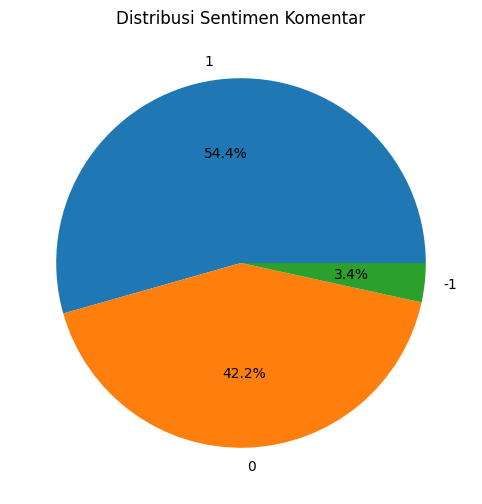

Distribusi Sentimen:
sentiment_label
 1    6527
 0    5060
-1     410
Name: count, dtype: int64


In [168]:
# Distribusi Sentimen
plt.figure(figsize=(10,6))
df_skz['sentiment_label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribusi Sentimen Komentar')
plt.ylabel('')
plt.show()

# Detail Distribusi
print("Distribusi Sentimen:")
print(df_skz['sentiment_label'].value_counts())

In [169]:
def advanced_sentiment_validation(sample_size=100):
    sample = df_skz.sample(sample_size)
    
    plt.figure(figsize=(12,8))
    for i, (index, row) in enumerate(sample.iterrows(), 1):
        print(f"Komentar {i}: {row['Comment_cleaned_slang']}")
        print(f"Label Sentimen: {row['sentiment_label']}")
        print("---")
    
    plt.tight_layout()
    plt.show()

# Jalankan validasi
advanced_sentiment_validation()

Komentar 1: ok day nooo hatee swear mean cu love music video crawling around
Label Sentimen: 1
---
Komentar 2: yall noticed since theyre animalsbeasts shapeshifters href theyre actually playing w cuz im mistaken animal wolf ferret play crawling top rolling floor explains laughing stuff moment
Label Sentimen: 1
---
Komentar 3: great tip thanks sharing
Label Sentimen: 1
---
Komentar 4: cooked hungrybrlive laugh lovebrskz
Label Sentimen: 1
---
Komentar 5: awesome
Label Sentimen: 1
---
Komentar 6: fantastic explanation thank
Label Sentimen: 1
---
Komentar 7: blove red light duob
Label Sentimen: 1
---
Komentar 8: great job video useful
Label Sentimen: 1
---
Komentar 9: well done appreciate video
Label Sentimen: 0
---
Komentar 10: music video fanfiction writer inspiration
Label Sentimen: 0
---
Komentar 11: guy im life support wtf christopher bang chan hwang hyunjin
Label Sentimen: -1
---
Komentar 12: pay gorn
Label Sentimen: 0
---
Komentar 13: exactly needed thanks
Label Sentimen: 1
---
Kome

<Figure size 1200x800 with 0 Axes>

In [170]:
# Sentimen berdasarkan likes
sentiment_likes = df_skz.groupby('sentiment_label')['Likes'].mean()
print("\nRata-rata Likes per Sentimen:")
print(sentiment_likes)

# Contoh komentar per sentimen
def show_sample_comments(sentiment):
    print(f"\nContoh Komentar {sentiment}:")
    samples = df_skz[df_skz['sentiment_label'] == sentiment]['Comment_cleaned_slang'].sample(5)
    for sample in samples:
        print(sample)

# Tampilkan sampel
show_sample_comments(1)  # Positif
show_sample_comments(-1)  # Negatif
show_sample_comments(0)  # Netral


Rata-rata Likes per Sentimen:
sentiment_label
-1    4.639024
 0    6.185968
 1    7.762372
Name: Likes, dtype: float64

Contoh Komentar 1:
railway bangchan thought music video concept abt train smth crazy brand escape ahhhh cant explain feel brbangchan u
bangchan hwang hyunjin boy cool incredible
stray kid comfortable want
speechless theyre insane
cute wolf

Contoh Komentar -1:
live performance bad need better even dance together even look screen see detail performance bad hope better start interact dancing even looking
love music video song dont hate ear hear song mix quotred lightsquot angst tempo new album song hwang hyunjin danced quotplay firequot try watching play fire downbeat tempo saying bad thing interesting
speechless need drama two kidding wan na cry wtf
today bad healed
psycho hyunchan im obsessed whaaaaat

Contoh Komentar 0:
yall see short scene red light video
need movie
uffff buenisimo
got goosebump sec song
keep streaming



--- Naive Bayes ---
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        87
      Netral       0.85      0.63      0.73      1001
     Positif       0.75      0.94      0.83      1312

    accuracy                           0.78      2400
   macro avg       0.53      0.52      0.52      2400
weighted avg       0.76      0.78      0.76      2400



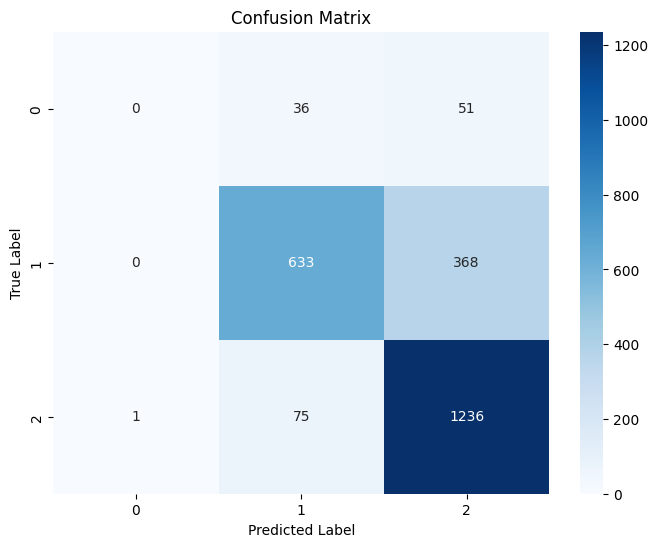


--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.96      0.28      0.43        87
      Netral       0.85      0.96      0.90      1001
     Positif       0.96      0.92      0.94      1312

    accuracy                           0.91      2400
   macro avg       0.92      0.72      0.76      2400
weighted avg       0.92      0.91      0.90      2400



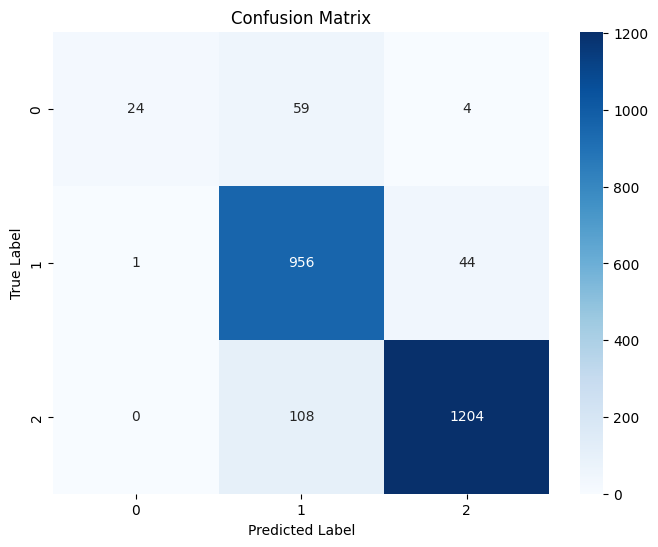


--- Support Vector Machine ---
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.90      0.30      0.45        87
      Netral       0.86      0.96      0.91      1001
     Positif       0.97      0.92      0.94      1312

    accuracy                           0.92      2400
   macro avg       0.91      0.73      0.77      2400
weighted avg       0.92      0.92      0.91      2400



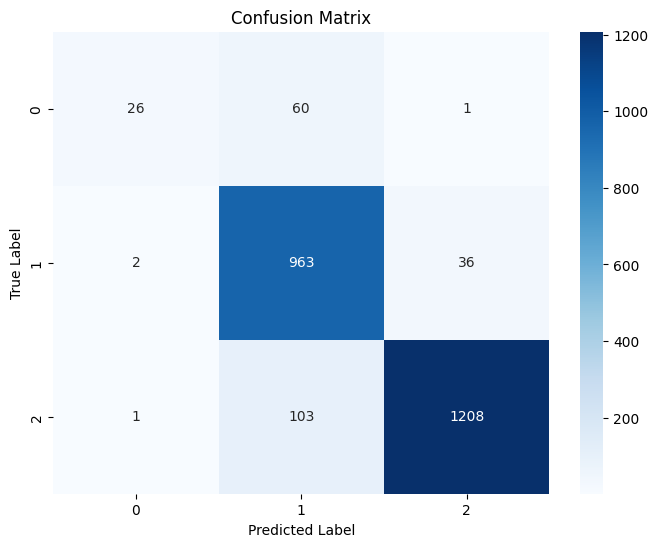

C:\Users\ichaa\AppData\Local\Temp\ipykernel_7756\2233821689.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skz['Predicted_Sentiment'] = best_model.predict(X)
C:\Users\ichaa\AppData\Local\Temp\ipykernel_7756\2233821689.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skz['Predicted_Sentiment_Label'] = df_skz['Predicted_Sentiment'].map({


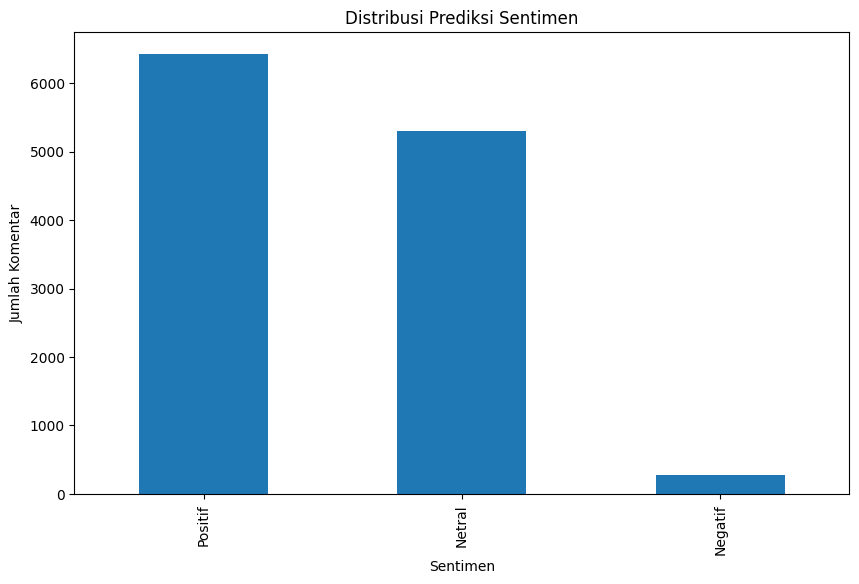

In [171]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_skz['Comment_cleaned_slang'])
y = df_skz['sentiment_encoded']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Fungsi Evaluasi Model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Training
    model.fit(X_train, y_train)
    
    # Prediksi
    y_pred = model.predict(X_test)
    
    # Evaluasi
    print("Classification Report:")
    print(classification_report(y_test, y_pred, 
        target_names=['Negatif', 'Netral', 'Positif']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return model

# Daftar Model
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC()
}

# Evaluasi Setiap Model
best_model = None
best_score = 0

for name, model in models.items():
    print(f"\n--- {name} ---")
    trained_model = evaluate_model(model, X_train, X_test, y_train, y_test)
    
    # Simpan model terbaik
    score = trained_model.score(X_test, y_test)
    if score > best_score:
        best_model = trained_model
        best_score = score

# Prediksi Keseluruhan Data
df_skz['Predicted_Sentiment'] = best_model.predict(X)

# Mapping Kembali
df_skz['Predicted_Sentiment_Label'] = df_skz['Predicted_Sentiment'].map({
    0: 'Negatif',
    1: 'Netral',
    2: 'Positif'
})

# Distribusi Prediksi
plt.figure(figsize=(10,6))
df_skz['Predicted_Sentiment_Label'].value_counts().plot(kind='bar')
plt.title('Distribusi Prediksi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Komentar')
plt.show()

In [172]:
# Tampilkan akurasi model terbaik
print(f"\nAkurasi model terbaik: {best_score:.2%}")


Akurasi model terbaik: 91.54%


In [173]:
df_skz.head()

,Author,Comment,Likes,Published_At,Replies,Cleaned_Comment,Comment_cleaned_slang,sentiment_label,sentiment_encoded,Predicted_Sentiment,Predicted_Sentiment_Label
0,@Raisha5594,My lovely bamgchan,0,2025-03-30T05:36:43Z,0,lovely bamgchan,lovely christopher bang chan,1,2,1,Netral
1,@adaniadaha5667,That high note they did😮,0,2025-03-30T05:13:12Z,0,high note,high note,0,1,1,Netral
2,@hotlatte-ev2gf,I like this concept,2,2025-03-30T05:07:30Z,0,concept,concept,0,1,1,Netral
3,@melizazueta,I love banchan especially kimchi,1,2025-03-30T04:29:00Z,0,love banchan especially kimchi,love christopher bang chan especially kimchi,1,2,2,Positif
4,@E.B1963,Ugh they both look like the hot toxic boyfrien...,2,2025-03-30T04:15:37Z,0,ugh look hot toxic boyfriend video pull psycho...,yes look hot toxic boyfriend video pull psycho...,1,2,2,Positif


In [174]:
# Tokenisasi dan Padding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_skz['Comment_cleaned_slang'])  # pakai kolom bersih
sequences = tokenizer.texts_to_sequences(df_skz['Comment_cleaned_slang'])
X = pad_sequences(sequences, maxlen=100)

# Label dan Train-Test Split
y = to_categorical(df_skz['sentiment_encoded'])  # label sudah siap
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df_skz['sentiment_encoded'], random_state=42)

Epoch 1/10


C:\Users\ichaa\anaconda3\envs\main-ds\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6350 - loss: 0.7429 - val_accuracy: 0.9000 - val_loss: 0.3090
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9194 - loss: 0.2554 - val_accuracy: 0.9021 - val_loss: 0.2841
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9610 - loss: 0.1167 - val_accuracy: 0.9187 - val_loss: 0.2397
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9832 - loss: 0.0480 - val_accuracy: 0.9254 - val_loss: 0.2558
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9893 - loss: 0.0318 - val_accuracy: 0.9271 - val_loss: 0.3269
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9915 - loss: 0.0252 - val_accuracy: 0.9262 - val_loss: 0.2962
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9937 - loss: 0.0208 - val_accuracy: 0.9242 - val_loss: 0.3422
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9962 - loss: 0.0137 - val_accuracy: 0.918

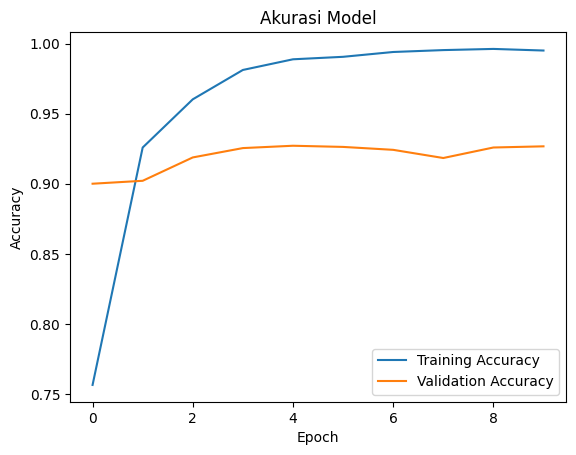

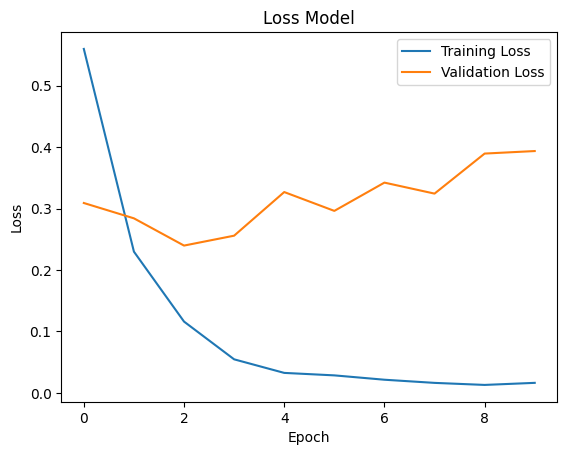

In [175]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Bangun Model LSTM 
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 kelas

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training Model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluasi Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi Testing Set: {accuracy*100:.2f}%")

# Visualisasi Akurasi dan Loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [206]:
# Fungsi untuk inference langsung
def predict_sentiment_skz(text):
    # Tokenisasi dan padding
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=100)
    
    # Prediksi
    prediction = model.predict(padded)
    
    # Mapping hasil
    sentiment_labels = ['Negatif', 'Netral', 'Positif']
    predicted_label = sentiment_labels[np.argmax(prediction)]
    
    # Confidence scores
    confidence = {label: float(score) for label, score in zip(sentiment_labels, prediction[0])}
    
    return predicted_label, confidence

# Contoh penggunaan langsung
test_comments = [
    "love christopher bang chan especially kimchi",
    "high note",
    "concept",
    "this song is amazing!", 
    "i don't like this, almost hate it", 
]

# Lakukan prediksi
for comment in test_comments:
    label, confidence = predict_sentiment_skz(comment)
    print(f"\nComment: {comment}")
    print(f"Predicted Sentiment: {label}")
    print("Confidence Scores:")
    for sentiment, score in confidence.items():
        print(f"{sentiment}: {score:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Comment: love christopher bang chan especially kimchi
Predicted Sentiment: Positif
Confidence Scores:
Negatif: 0.000
Netral: 0.000
Positif: 1.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Comment: high note
Predicted Sentiment: Netral
Confidence Scores:
Negatif: 0.000
Netral: 1.000
Positif: 0.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Comment: concept
Predicted Sentiment: Netral
Confidence Scores:
Negatif: 0.000
Netral: 0.999
Positif: 0.001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Comment: this song is amazing!
Predicted Sentiment: Positif
Confidence Scores:
Negatif: 0.000
Netral: 0.000
Positif: 1.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Comment: i don't like this, almost hate it
Predicted Sentiment: Negatif
Confidence Scores:
Negatif: 1.000
Netral: 0.000
Positif: 0.000


In [208]:
df_skz.head()

,Author,Comment,Likes,Published_At,Replies,Cleaned_Comment,Comment_cleaned_slang,sentiment_label,sentiment_encoded,Predicted_Sentiment,Predicted_Sentiment_Label
0,@Raisha5594,My lovely bamgchan,0,2025-03-30T05:36:43Z,0,lovely bamgchan,lovely christopher bang chan,1,2,1,Netral
1,@adaniadaha5667,That high note they did😮,0,2025-03-30T05:13:12Z,0,high note,high note,0,1,1,Netral
2,@hotlatte-ev2gf,I like this concept,2,2025-03-30T05:07:30Z,0,concept,concept,0,1,1,Netral
3,@melizazueta,I love banchan especially kimchi,1,2025-03-30T04:29:00Z,0,love banchan especially kimchi,love christopher bang chan especially kimchi,1,2,2,Positif
4,@E.B1963,Ugh they both look like the hot toxic boyfrien...,2,2025-03-30T04:15:37Z,0,ugh look hot toxic boyfriend video pull psycho...,yes look hot toxic boyfriend video pull psycho...,1,2,2,Positif


In [210]:
X_text = df_skz['Comment_cleaned_slang']  # teks komentar
y = df_skz['sentiment_encoded']  # label numerik: 0 = negatif, 1 = netral, 2 = positif

#TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(X_text)

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train SVM
model = LinearSVC()
model.fit(X_train, y_train)

#Evaluasi
y_pred = model.predict(X_test)
print("Akurasi: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

#Inference contoh manual
sample = ["this song is amazing!", "i don't like this", "hmm it's okay i guess"]
sample_vec = vectorizer.transform(sample)
sample_pred = model.predict(sample_vec)

#Konversi label angka ke nama
label_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
pred_labels = [label_map[i] for i in sample_pred]

for s, p in zip(sample, pred_labels):
    print(f"{s} => {p}")

Akurasi: 92.83%

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.49      0.62        87
           1       0.89      0.95      0.92      1001
           2       0.96      0.94      0.95      1312

    accuracy                           0.93      2400
   macro avg       0.90      0.79      0.83      2400
weighted avg       0.93      0.93      0.93      2400

this song is amazing! => Positif
i don't like this => Netral
hmm it's okay i guess => Positif
